## 1. Importing the necessary libraries and defining constants.

In [158]:
import polars as pl
import polars.selectors as sc
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

import pathlib as path
import shutil 

 # Define the ratio of the plot.
fig_aspect_ratio : float = 4/3 # width/height ratio
height : float = 6
width: float = height * fig_aspect_ratio


# Assign an ordinal number to each month to promote the proper order of the months in directories (January, February etc.)
month_order : dict[str, int] = {
                "January":1,
                "February":2,
                "March":3,
                "April":4,
                "May":5,
                "June":6,
                "July":7,
                "August":8,
                "September":9,
                "October":10,
                "November":11,
                "December":12
                }
int2month : dict[int, str] = {month_order[key] : key for key in month_order.keys()}

            
main_path: path.Path = path.Path(input("Please, type your destination directory"))/"Financial summaries"


if main_path.exists():
    shutil.rmtree(main_path)

# 2. Reading the data from Excel sheets.

In [159]:
# Read the expenses data from the Excel file.
expenses_df = pl.read_excel(
    "Expenses.xlsx",
    sheet_name="Expenses",
    has_header=True
)

# Read the income data from the Excel file.
income_df = pl.read_excel(
    "Incomes.xlsx",
    sheet_name="Incomes",
    has_header=True
)

# Display the expenses DataFrame.
expenses_df

Expense date,Where bought?,What bought?,Expense cost,Volume unit,Volume amount,Expense category,Product category
date,str,str,f64,str,f64,str,str
2024-02-01,"""Biedronka""","""Ser żółty światowid""",13.98,"""gram""",600.0,"""Groceries""","""Ser"""
2024-02-01,"""Biedronka""","""Woda gazowana muszynianka""",2.99,"""ml""",1500.0,"""Drinks""","""Woda"""
2024-02-01,"""Biedronka""","""Ryż brązowy plony natury""",5.98,"""gram""",800.0,"""Groceries""","""Ryż"""
2024-02-01,"""Biedronka""","""Serek wiejski""",5.97,"""gram""",600.0,"""Groceries""","""Serek wiejski"""
2024-02-01,"""Biedronka""","""Olej słonecznikowy""",7.99,"""ml""",1000.0,"""Groceries""","""Olej spożywczy"""
…,…,…,…,…,…,…,…
2025-02-28,"""Biedronka""","""Cebula dymka""",2.99,"""sztuka""",1.0,"""Groceries""","""Cebula"""
2025-02-28,"""Biedronka""","""Czosnek""",1.98,"""sztuka""",1.0,"""Groceries""","""Czosnek"""
2025-02-28,"""Biedronka""","""Jabłko polskie gala luz""",3.32,"""gram""",665.0,"""Groceries""","""Jabłka"""


# 3. Grouping the costs by month and year.

In [160]:
# Group the expenses by year, quarter, and month, then sum the costs.
grouped_expenses = (
    expenses_df.group_by(
        pl.col("Expense date").dt.year().alias("Year"),
        pl.col("Expense date").dt.quarter().alias("Quarter"),
        pl.col("Expense date").dt.strftime("%b").alias("Month"),
        maintain_order=True
    ).agg(
        pl.col("Expense cost").sum().alias("Total expenses")
    )
)

# Group the incomes by year, quarter, and month, then sum the amounts.
grouped_income = (
    income_df.group_by(
        pl.col("Income date").dt.year().alias("Year"),
        pl.col("Income date").dt.quarter().alias("Quarter"),
        pl.col("Income date").dt.strftime("%b").alias("Month"),
        maintain_order=True
    ).agg(
        pl.col("Income amount").sum().alias("Total incomes")
    )
)


# 4. Preprocessing the balance sheets for plotting.

In [161]:
# Join the grouped_income with grouped_expenses on Year and Month columns.
balances = (
    grouped_income.join(
        grouped_expenses,
        on=(pl.col("Year"), pl.col("Month")),
        how="full",
        suffix="_expense"
    )
)

def determine_date_component(row: tuple, idx1: int, idx2: int) -> str | int:
    """
    Determine the date component (Year, Month, Quarter) for each record in the 'balances' dataframe.
    This is crucial as we need to manually check for missing values in the date columns.

    Parameters:
    ----------
    row : tuple
        A record of a dataframe.
    idx1 : int
        The position of the first date_component column.
    idx2 : int
        The position of the second date_component column.

    Returns:
    -------
    str | int
        A date component (string for months; integer for years and quarters).
    """
    def determine(row: tuple) -> str | int:
        if row[idx1] is None:
            return row[idx2]
        elif row[idx2] is None:
            return row[idx1]
        else:
            return row[idx1]
        
    return determine(row)

# Create columns for Year, Quarter, and Month by mapping the determine_date_component function.
year_col: pl.Series = balances.map_rows(lambda row: determine_date_component(row, 0, 4), pl.Int16).to_series().alias("Year")
quarter_col: pl.Series = balances.map_rows(lambda row: determine_date_component(row, 1, 5), pl.Int8).to_series().alias("Quarter")
month_col: pl.Series = balances.map_rows(lambda row: determine_date_component(row, 2, 6), pl.String).to_series().alias("Month")

# Add the new date component columns to the balances dataframe and drop the original date columns with suffix "_expense".
balances = balances.with_columns(year_col, quarter_col, month_col).drop(balances.select(sc.ends_with("_expense")).columns).fill_null(0)

# Add a column "Monthly balance" by subtracting Total expenses from Total incomes.
balances = balances.with_columns(
    (pl.col("Total incomes") - pl.col("Total expenses")).alias("Monthly balance")
)

# Convert the balance sheet to long form.
balances_long = balances.unpivot(
    index=("Year", "Quarter", "Month"),
    variable_name="Financial category",
    value_name="Amount"
)

# 5. Visualizing the annual general balance sheets.

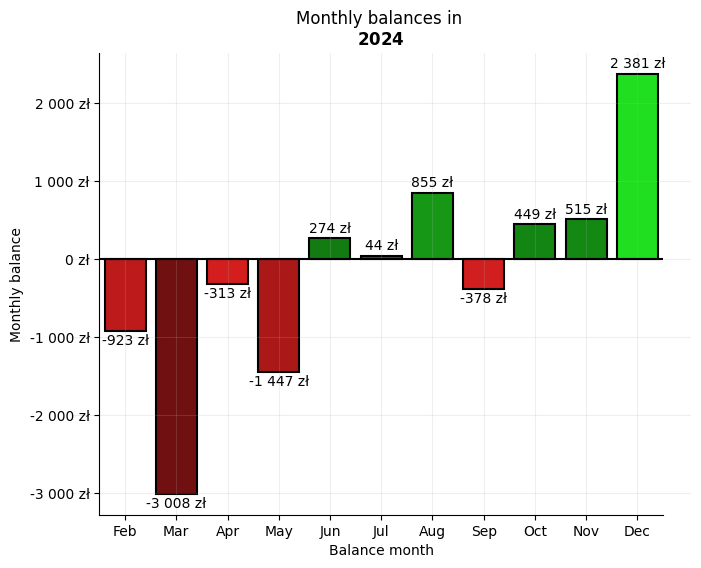

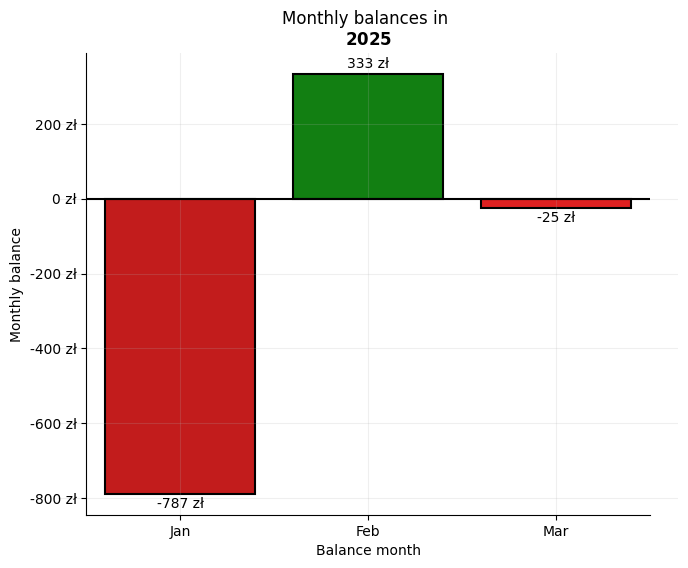

In [162]:
# Filter the balances_long DataFrame to get only the monthly balances.
monthly_balances = balances_long.filter(
    pl.col("Financial category").str.ends_with("balance")
)

# Create a Normalizer for our data for the color map to work properly.
normalize = colors.Normalize(
    monthly_balances["Amount"].min(),
    monthly_balances["Amount"].max()
)

# Find the "turning" normalized value (that is, if normalize(x) < x0 then x is negative, otherwise - positive).
x0 = normalize(0)

# Define the color entries for the LinearSegmentedColorMap.
red = [(0, 0, 0.5), (x0, 1, 0), (1, 0, 0)]
green = [(0, 0, 0), (x0, 0, 0.5), (1, 1, 1)]
blue = [(0, 0, 0), (1, 0, 0)]
alpha = [(0, 1, 1), (x0, 0, 0), (1, 1, 1)]

# Create a custom color map.
financial_colormap = colors.LinearSegmentedColormap(
    "FinancialPalette",
    {"red": red, "green": green, "blue": blue, "alpha": alpha}
)


def generate_month_balance_sheet(year: int) -> None:
    """The function generates the month balance sheet plot for a given year. All of the plots are saved in a given path.
    
    Parameters:
    ---------
    year: int
        The year of the month balances.

    Returns:
    None
    """
    # Filter the balance sheet by year.
    df_filtered = monthly_balances.filter(pl.col("Year") == year)

    # Convert the values to color.
    kolory = [financial_colormap(normalize(v)) for v in df_filtered["Amount"]]

    # Create a figure.
    global width, height
    figure = plt.figure(figsize=(width, height))
    axes = sns.barplot(
        data=df_filtered, 
        x="Month", 
        y="Amount", 
        palette=kolory, 
        hue="Month", 
        legend=False,
        edgecolor="black", 
        linewidth=1.5
    )

    # Customizing the plot.
    axes.spines[["top", "right"]].set_visible(False)
    axes.grid(True, alpha=0.2)

    # Setting the title of the plot and axis labels.
    axes.set_title(f"Monthly balances in \n$\\bf{{{year}}}$")
    axes.set_ylabel("Monthly balance")
    axes.set_xlabel("Balance month")

    # Adjust the bounds of the bottom spine.
    xlim = axes.get_xlim()
    axes.spines["bottom"].set_bounds(xlim[0], xlim[1])

    # Set the position of the left spine.
    axes.spines["left"].set_position(("data", xlim[0]))

    # Add a new Ox axis at position y=0.
    axes.hlines(0, xlim[0], xlim[1], colors="black")

    # Set the major formatter for the y-axis.
    axes.yaxis.set_major_formatter(lambda x, v: f"{x:,.0f} zł".replace(",", " "))

    # Add labels to the bars.
    for container in axes.containers:
        axes.bar_label(container, fmt=lambda v: f"{v:,.0f} zł".replace(",", " "), padding=2)

    # Define the saving path.
    saving_path = main_path / f"{year}"

    if not saving_path.exists():
        saving_path.mkdir(parents=True)

    # Save the figure.
    figure.savefig(fname=saving_path / "General monthly balances.png")

# Generate the month balance sheets for each year available in the dataset.
for year in monthly_balances["Year"].unique():
    generate_month_balance_sheet(year)


# 6. Visualizing the income and expenses for each month.

In [170]:
monthly_detailed_balances_path = path.Path().cwd() / "Detailed monthly balances"

def generate_month_detailed_balances(year: int) -> None:
    """Generate the month detailed balance sheet plot for a given year and save it.

    Parameters:
    ---------
    year: int
        The year of the month balances.

    Returns:
    None
    """
    # Filter the balance sheets and add a new column for "signed" amount.
    year_balance_sheets = balances_long.filter(
        pl.col("Year") == year,
        pl.col("Financial category").str.starts_with("Total")
    )

    # Create a FacetGrid for the quarters.
    facet_grid = sns.FacetGrid(
        data=year_balance_sheets, 
        col="Quarter", 
        col_wrap=min(2, year_balance_sheets["Quarter"].n_unique()), 
        sharex=False, 
        sharey=False
    )

    # Set title for each subplot.
    facet_grid.set_titles(template="Monthly balances in {col_name}th quarter")

    # Set the global title for the whole figure.
    facet_grid.fig.suptitle(
        fr"Detailed monthly balances for  $\bf{{{year}}}$",
        size=15
    )
    facet_grid.fig.subplots_adjust(top=0.9)  # Lift the title a little bit.

    for quarter_id, axes in facet_grid.axes_dict.items():
        # Find the rows from a given quarter.
        quarter_balance_sheets = year_balance_sheets.filter(pl.col("Quarter") == quarter_id)

        sns.barplot(
            data=quarter_balance_sheets, 
            x="Month", 
            y="Amount", 
            hue="Financial category",
            ax=axes,
            palette={"Total expenses": "red", "Total incomes": "green"},
            edgecolor="black",
            linewidth=1.75
        )

        # Find the minimum and maximum amount respectively.
        y_min, y_max = quarter_balance_sheets["Amount"].min(), quarter_balance_sheets["Amount"].max()

        axes.get_legend().set_title("")
        axes.set_xlabel("Balance month", labelpad=-1)
        axes.set_ylim(0, y_max * (1.1 + (y_max - y_min) / y_max))
        axes.yaxis.set_major_formatter(lambda x, v: f"{x:,.0f} zł".replace(",", " "))
        axes.grid(True, alpha=0.3)

        # Add bar labels.
        for container in axes.containers:
            axes.bar_label(container, fmt=lambda v: f"{v:,.0f}".replace(",", " "), padding=2)

        # Resize the width of the bars so that the bar labels wouldn't overlap.
        q = 0.7
        for patch in axes.patches:
            current_width = patch.get_width()
            patch.set_width(current_width * q)
            patch.set_x(patch.get_x() + current_width / 2 * (1 - q))

    # Get the figure.
    figure = axes.get_figure()

    # Change the shapes of the figure.
    figure.set_size_inches((8 * fig_aspect_ratio, 8))

    # Define the saving path.
    saving_path = main_path / f"{year}"

    if not saving_path.exists():
        saving_path.mkdir(parents=True)

    # Save the figure.
    figure.savefig(saving_path / "Detailed monthly balances")

    plt.close()
    
# Generate the month detailed balance sheets for each year available in the dataset.
for year in balances_long["Year"].unique():
    generate_month_detailed_balances(year)

# 7. Visualizing the share of expense categories in monthly spendings.

In [164]:
def plot_the_share(df: pl.DataFrame, date_col: str, cat_col: str, cost_col: str, transaction_type: str) -> None:
    """The function visualizes the categories share in either expenses or incomes.

    Parameters:
    df : pl.DataFrame
        The dataframe storing the expenses or incomes.

    date_col : str
        The name of the date column.

    cat_col : str
        The name of the (expense/income) category column.

    cost_col : str
        The name of the cost column.

    transaction_type : str
        One of two types of transaction (expenses, incomes) we're visualizing.
    """
    cat_share = df.group_by(
        pl.col(date_col).dt.year().alias("Year"),
        pl.col(date_col).dt.strftime("%B").alias("Month"),
        pl.col(cat_col)
    ).agg(
        pl.sum(cost_col).alias("Total amount")
    )

    for year in cat_share["Year"].unique():
        for month in cat_share["Month"].unique():
            # Filter out the monthly expenses and add a normalized amount of the expenses.
            cat_share_filtered = cat_share.filter(
                (pl.col("Year") == year) & (pl.col("Month") == month)
            ).with_columns(
                (100 * pl.col("Total amount") / pl.sum("Total amount")).alias('Share')
            )

            if cat_share_filtered.shape[0]:
                # Create a condition to group the least-expensive categories.
                grouping_condition = pl.when(pl.col("Share") <= 1.5).then(
                    pl.lit("Other")
                ).otherwise(
                    pl.col(cat_col)
                ).alias(cat_col)

                # Group the least-expensive categories together.
                cat_share_filtered = cat_share_filtered.with_columns(
                    grouping_condition
                ).group_by(
                    pl.col(cat_col)
                ).agg(
                    pl.sum("Total amount"), pl.sum("Share")
                ).sort(
                    pl.col("Share"), descending=True
                )

                # Create a figure.
                fig, ax = plt.subplots(figsize=(6, 3))

                # Resize the figure.
                global height, width
                fig.set_size_inches(width, height)

                wedges, _ = plt.pie(
                    cat_share_filtered["Share"],
                    wedgeprops={"edgecolor": (0, 0, 0, 0.75), "linewidth": 1},
                )

                # Find the labels of each wedge.
                labels = cat_share_filtered[cat_col]

                # Define the formatter for percentage share.
                text_formatter = lambda t: f"{t:.2f}"

                for label, wedge, share in zip(labels, wedges, cat_share_filtered["Share"]):
                    # Find the starting and ending angles of the wedge.
                    theta1, theta2 = wedge.theta1, wedge.theta2

                    # Find the radius of the wedge.
                    radius = wedge.r

                    # Find the angle of the point the label will be located at.
                    angle = np.deg2rad((theta1 + 2 * theta2) / 3)

                    # Find the coordinates of the circle edge point.
                    x, y = np.cos(angle) * radius, np.sin(angle) * radius

                    # The point from the circumference.
                    xy = np.array([x, y])

                    # The tail point scaling factor.
                    q = 1.2 if x >= 0 else (1.2 if y >= 0 else 1.3)

                    # The arrow tail coordinates scaling factor, which should be in the [0;1] interval.
                    s = 0.9

                    # Find the tail and head of the arrow.
                    arrow_tail_xy, arrow_head_xy = s * xy, q * xy

                    # Create a good-looking label depending on the orientation of the wedge.
                    text = (label.replace(" ", "\n") + (", " if x >= 0 else "\n") + fr"$\bf{{{text_formatter(share)}}}\%$")

                    ax.annotate(
                        text=text, xy=arrow_tail_xy, xytext=arrow_head_xy,
                        arrowprops={"arrowstyle": "<-", "connectionstyle": "Angle3", "color": "black", "linewidth": 1, "linestyle": "dashed"},
                        fontsize=9
                    )

                ax.set_title(
                    f"Monthly categories share in {transaction_type.lower()} in " + rf"$\bf{{{month}, {year}}}$",
                    loc="right", fontsize=12
                )

                # Save the figure.
                saving_path = main_path / f"{year}" / f"{month_order[month]} {month}"
                saving_path.mkdir(parents=True, exist_ok=True)

                fig.savefig(fname=saving_path / f"Cat. share in {transaction_type.lower()}.png")
                plt.close()

# Plot the share for expenses and incomes.
plot_the_share(expenses_df, "Expense date", "Expense category", "Expense cost", "Expenses")
plot_the_share(income_df, "Income date", "Income category", "Income amount", "Incomes")

# 8. Total categorical monthly costs.

In [ ]:
# Iterate over each unique year in the "Expense date" column of expenses_df.
for year in expenses_df["Expense date"].dt.year().unique():
    # Filter the expenses by the current year and group them by month and category.
    # Sum the total cost for each group.
    total_monthly_expenses = (
        expenses_df.filter(pl.col("Expense date").dt.year() == year)
        .group_by(
            pl.col("Expense date").dt.strftime("%B").alias("Month"),
            pl.col("Expense category").alias("Category")
        ).agg(
            pl.sum("Expense cost").round(2).alias("Total cost")
        ).sort(
            pl.col("Month").replace_strict(month_order)
        )
    )

    # Transform the dataframe to wide form.
    total_monthly_expenses = total_monthly_expenses.pivot(
        index="Category",
        on="Month",
        values="Total cost"
    ).fill_null(0)

    # Define the saving path for the current year's total monthly expenses.
    saving_path = main_path / rf"{year}" / "Total monthly"
    saving_path.mkdir(parents=True, exist_ok=True)

    # Convert the dataframe to a pandas dataframe and set the index to "Category".
    total_monthly_expenses_pd: pd.DataFrame = total_monthly_expenses.to_pandas().set_index("Category")

    # Create a figure and axes for the heatmap.
    figure = plt.figure()
    axes = figure.add_subplot()

    # Set the size of the figure.
    figure.set_size_inches(fig_aspect_ratio * 8, 8)

    # Create a heatmap of the total monthly expenses.
    sns.heatmap(
        total_monthly_expenses_pd, vmin=0, vmax=total_monthly_expenses_pd.max().max(),
        cmap="coolwarm", annot=True, ax=axes, fmt=" .0f",
        annot_kws={"fontsize": 7, "weight": 600}, cbar=False,
        linecolor="black", linewidths=0.5
    )

    # Set the title and labels for the heatmap.
    axes.set_title(f"Total monthly expenses for each category in\n$\\bf{{{year}}}$")
    axes.set_xlabel("Month", weight=600)
    axes.set_ylabel("Category", weight=600)

    # Rotate the x-axis tick labels for better readability.
    axes.tick_params(axis='x', rotation=60)

    # Save the heatmap as a PNG file.
    figure.savefig(saving_path / "Total monthly expenses.png")
    plt.close()

# 9. Total categorical monthly incomes.

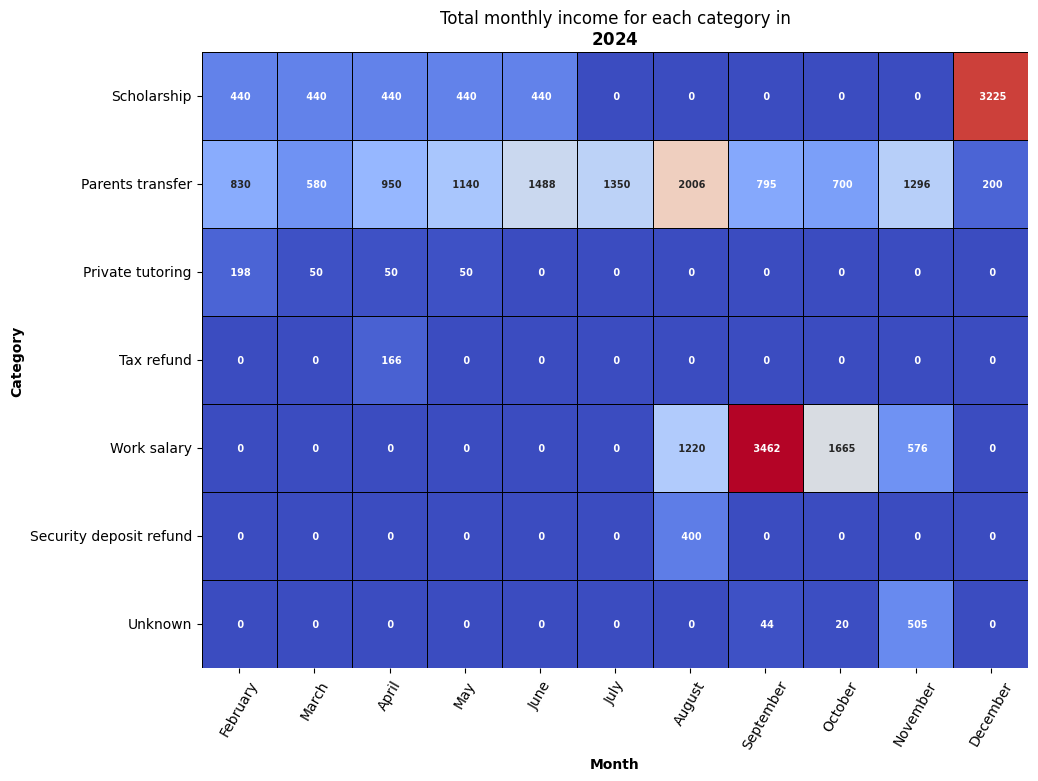

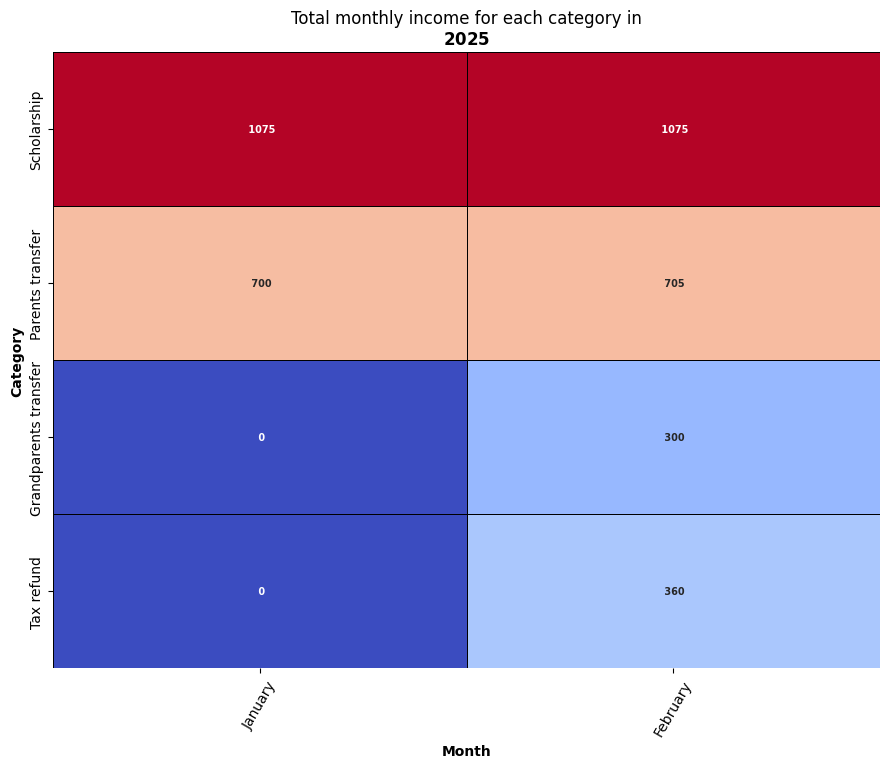

In [166]:
for year in income_df["Income date"].dt.year().unique():
    # Filter the incomes by year 
    # and group them by month and categories 
    # and then sum the total cost for each group.
    total_monthly_income = (
        income_df.filter(pl.col("Income date").dt.year() == year)
        .group_by(
            pl.col("Income date").dt.strftime("%B").alias("Month"),
            pl.col("Income category").alias("Category")
        ).agg(
            pl.sum("Income amount").round(2).alias("Total income")
        ).sort(
            pl.col("Month").replace_strict(month_order)
        )
    )


    # Let's transforme the dataframe to wide form.
    total_monthly_income = total_monthly_income.pivot(
        index="Category",
        on="Month",
        values="Total income"
    ).fill_null(0)
 

    # Declare a saving path.
    saving_path = main_path/rf"{year}"/f"Total monthly"

    # Create the directory.
    saving_path.mkdir(parents = True, exist_ok = True)


    # Convert the dataframe to pandas dataframe.
    total_monthly_income_pd : pd.DataFrame = total_monthly_income.to_pandas().set_index("Category")

    figure = plt.figure()
    axes = figure.add_subplot()

    figure.set_size_inches(fig_aspect_ratio*8, 8)

    sns.heatmap(total_monthly_income_pd, vmin = 0, vmax = total_monthly_income_pd.max().max(),
    cmap = "coolwarm", annot = True, ax = axes,fmt=" .0f",
    annot_kws={"fontsize":7, "weight":600}, cbar = False,
    linecolor = "black",
    linewidths = 0.5)


    axes.set_title("Total monthly income for each category in\n"+rf"$\bf{{{year}}}$")

    axes.set_xlabel("Month", 
                    weight = 600)
    
    axes.set_ylabel("Category",
                    weight = 600)
    
    axes.tick_params(axis = 'x', 
                    rotation = 60)


    figure.savefig(saving_path/"Total monthly income.png")



# 10. Expense categories monthly frequencies.


In [167]:
for year in expenses_df["Expense date"].dt.year().unique():
    # Filter the expenses for the specified year and get unique entries.
    df = expenses_df.filter(
        pl.col("Expense date").dt.year() == year
    ).unique(
        ["Expense date", "Where bought?", "Expense category"],
        maintain_order=True
    )

    # Group by month and expense category, then count the occurrences.
    df = df.group_by(
        pl.col("Expense date").dt.strftime("%B").alias("Month"),
        pl.col("Expense category"),
        maintain_order=True
    ).agg(
        pl.count("Expense category").alias("Count").round(2)
    )

    # Calculate the frequency and drop the count column.
    df = (
        df.with_columns(
            (100 * pl.col("Count") / pl.sum("Count").over(pl.col("Month"))).round(1).alias("Frequency")
        )
        .drop("Count")
        .sort(
            pl.col("Month").replace_strict(month_order)
        )
    )


    # Convert the dataframe to wide form.
    df = df.pivot(on = "Month", 
                index = "Expense category", 
                values = "Frequency").fill_null(0)


    df_pd: pd.DataFrame = df.to_pandas().set_index("Expense category")

    figure = plt.figure()
    axes = figure.add_subplot()

    figure.set_size_inches(fig_aspect_ratio*8, 8)

    sns.heatmap(df_pd, cmap = "YlGnBu",vmin = 0, vmax = df_pd.max().max(),
                annot = True, ax = axes,
                cbar = False,
                linewidths = 0.5
                ,linecolor = "black")

    axes.set_title(label = "Monthly frequencies in \n"+fr"$\bf{{{year}}}$")
    axes.set_xlabel("Month", 
                    weight = 600)
    axes.set_ylabel("Category",
                    weight = 600)

    axes.tick_params(axis = 'x', 
                    rotation = 60)
    
    figure.savefig(main_path/f"{year}"/"Monthly frequencies.png")
    plt.close()




# 11. The daily cost distributions. 

In [168]:
def annotate_number(axes:plt.axes, num:float, y:float, ha:str = "right"):
    axes.annotate(f"{num:.0f}",
                    (num, 0.8*y),
                    va = "bottom",
                    ha = ha)
    
    return axes.vlines(num, 0, 0.8*y, color="red", 
                       linewidth=2)


# Define a cost formatter function
cost_formatter: callable = lambda v: f"{v:,.0f}".replace(",", "")  # Format numbers with no commas

# Define a function to find the closest point in an array
find_closest_point: callable = lambda x0, x: np.argmin(abs(x0 - x))


expenses_df_grouped: pl.DataFrame = expenses_df.group_by(pl.col("Expense date"), pl.col("Expense category")).agg(
                pl.sum("Expense cost").alias("Cost")
            )

for year in expenses_df["Expense date"].dt.year().unique():
    for month in expenses_df["Expense date"].dt.month().unique():
        saving_path = main_path/f"{year}"/f"{month} {int2month[month]}"/f"Expense distributions"
  
        for category in expenses_df["Expense category"].unique():
            # Filter the expenses data by year, month, and category
            cat_df: pl.DataFrame = expenses_df_grouped.filter(
                pl.col("Expense date").dt.year() == year,
                pl.col("Expense date").dt.month() == month,
                pl.col("Expense category") == category
            )

            if cat_df.shape[0]:
                # Check if the dataframe has at least two records
                has_min_two: bool = cat_df.shape[0] > 1


                # Compute the mean and standard deviation of the costs
                mean: float = cat_df["Cost"].mean()
                sd: float = 0 if not has_min_two else cat_df["Cost"].std()


                # Create a figure and axes for plotting
                fig = plt.figure()
                axes = fig.add_subplot()


                # If the standard deviation is greater than zero, plot the estimated density
                if sd > 0:
                    sns.kdeplot(cat_df, x="Cost", linewidth=2, ax=axes)

                    # Get the data points from the plot
                    X, Y = axes.get_lines()[0].get_data()


                    # Generate points within the interval [mean - sd, mean + sd]
                    x: np.ndarray = np.arange(mean - sd, mean + sd, 0.01)


                    # Vectorize the 'find_closest_point' function
                    find_closest_point_vec: callable = np.vectorize(find_closest_point, excluded=["x"])


                    # Find the indices of the closest points
                    min_idx: np.ndarray = find_closest_point_vec(x0=x, x=X)


                    # Compute the y-coordinates of the closest points
                    y: np.ndarray = Y[min_idx]

                    # Estimate the probability the cost will lie between (mean-sd, mean+sd)
                    prob: float = np.sum((x[1:]-x[:-1])*y[1:])

                    # Fill the area within one standard deviation from the mean
                    area = axes.fill_between(x=x, y1=0, y2=y, color="red", alpha=0.2)


                    # Draw a vertical line at the mean
                    mean_y: float  = y[find_closest_point(mean, X)]

                    mean_line = annotate_number(axes, mean, 0.8*mean_y)

                    
                    # Find the heights of the (mean-sd) and (mean +sd) points respectively.
                    left_y: float = y[find_closest_point(mean-sd, X)]
                    right_y: float = y[find_closest_point(mean+sd, X)]

                    annotate_number(axes, mean-sd, 0.2*left_y)
                    annotate_number(axes, mean+sd, 0.2*right_y, ha = "left")

                    # Add a legend to the plot
                    axes.legend(handles=[area, mean_line], labels=[f"One-sd from mean interval, with {100*prob:.0f}% prob.", "Expectation"],
                                loc = "upper left",
                                framealpha = 0.4)

                

                # If the standard deviation is zero, plot a bar chart
                else:
                    atom = cat_df["Cost"][0]

                    sns.barplot(x=[atom], y=[1], width=0.2, edgecolor="black", linewidth=2)

                    # Set the x-axis limits
                    axes.set_xlim(0, 1)
                    bar = axes.containers[0][0]

                    # Find the anchor of the bar
                    x, y = 0.5 - bar.get_width() / 2, 0
                    bar.set_xy(xy=(x, y))

                    # Set the x-axis ticks and labels
                    axes.set_xticks([0, x + bar.get_width() / 2], labels=["0", cost_formatter(atom)])


                # Add grid lines and hide the top and right spines
                axes.grid(True, alpha=0.4)
                axes.spines[["top", "right"]].set_visible(False)
                axes.set_title("The cost distribution for \n"+rf"$\bf{{{category}}}$")

                if not saving_path.exists():
                    saving_path.mkdir(parents = True)
                fig.savefig(saving_path/f"{category} costs distribution.png")
                plt.close()
